### ACO (Ant Colony Optimization) algorithm for shortest path problem

The code below uses ACO to determine the shortest path between `num_nodes` nodes that are
<br> randomly generated. <br><br>ACO, like Genetic Algorithms, is a heuristic based algorithm. <br>
It does not guarantee optimality, but near optimal solutions (which maybe acceptable for a particular problem)

In [1]:
num_nodes = 50

In [2]:
import networkx as nx
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
from statistics import mean

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:

xs = [np.random.randint(100, 1000) for _ in range(num_nodes)]
ys = [np.random.randint(100, 1000) for _ in range(num_nodes)]

### Generate the distances 

In [5]:
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt(math.pow(x1-x2, 2) + math.pow(y1-y2, 2))

distance_matrix = np.array([
        distance((xs[i], ys[i]), (xs[j], ys[j])) for i in range(num_nodes) for j in range(num_nodes)
    ]).reshape(num_nodes,num_nodes)

distance_df = pd.DataFrame(distance_matrix)
distance_df.head(10)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,228.816520,406.669399,315.683386,463.487864,627.400988,42.953463,458.835482,408.285439,475.420866,...,368.989160,357.576565,291.006873,644.736380,397.363813,491.736718,283.534830,587.054512,394.068522,113.863954
1,228.816520,0.000000,624.923195,305.353893,442.922115,411.004866,226.384628,235.076583,271.400074,506.098805,...,430.278979,268.544224,457.831847,433.847900,410.600779,536.436390,445.000000,370.299878,273.724314,277.016245
2,406.669399,624.923195,0.000000,524.309069,793.282421,983.099181,430.029069,859.773226,805.893914,534.083327,...,646.947448,624.923195,237.918053,990.467062,713.354050,752.484551,460.525786,991.875496,677.555902,439.396177
3,315.683386,305.353893,524.309069,0.000000,725.623180,492.804221,352.614520,482.860228,576.753847,201.069640,...,668.350956,109.622078,290.408333,490.249936,676.208548,788.269624,598.344382,619.939513,163.027605,427.907700
4,463.487864,442.922115,793.282421,725.623180,0.000000,751.242304,421.390555,474.081217,242.787973,915.897374,...,162.603813,709.839418,749.566541,787.027318,81.271151,151.419946,354.153921,503.167964,716.358151,372.131697
5,627.400988,411.004866,983.099181,492.804221,751.242304,0.000000,633.754684,278.111488,509.934309,636.491163,...,801.439330,383.537482,768.117830,40.360872,754.067636,883.351006,852.877482,315.748317,331.556933,688.021075
6,42.953463,226.384628,430.029069,352.614520,421.390555,633.754684,0.000000,448.001116,377.708883,517.117008,...,326.450609,386.597982,330.605505,653.460022,354.565932,449.134724,251.525347,571.405285,419.586701,75.471849
7,458.835482,235.076583,859.773226,482.860228,474.081217,278.111488,448.001116,0.000000,231.976292,676.184147,...,538.023234,401.019950,687.404539,315.285585,482.534973,610.181121,621.921217,139.645981,373.100523,480.534078
8,408.285439,271.400074,805.893914,576.753847,242.787973,509.934309,377.708883,231.976292,0.000000,777.417520,...,330.106044,531.159110,690.857438,546.561982,261.489962,384.096342,460.492128,272.264577,523.955151,372.204245
9,475.420866,506.098805,534.083327,201.069640,915.897374,636.491163,517.117008,676.184147,777.417520,0.000000,...,842.854673,277.510360,308.755567,623.570365,860.770004,965.088597,743.008075,810.127151,317.441333,588.640807


### Draw the graph

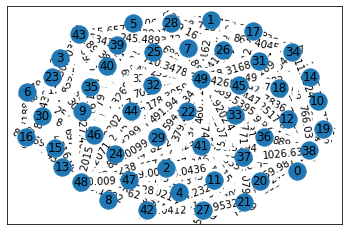

In [6]:
G = nx.Graph()
for u in distance_df.index:
    for v in distance_df.columns:
        G.add_edge(u, v, distance=distance_df.loc[u,v])
        
pos = nx.spring_layout(G)
edge_labels = {
    (r, c): round(distance_df.loc[r,c], 4) for r in distance_df.index for c in distance_df.columns if r != c and r > c
}
nx.draw_networkx(G, pos)
ret = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.7)

### ACO parameters

In [7]:
max_iterations = 100
num_ants = 50
tau_0 = (10/(num_nodes * mean(edge_labels.values()))) # initial pheromone concentration
tau_matrix = tau_0 * np.ones((num_nodes, num_nodes))
np.fill_diagonal(tau_matrix, 0)
tau_df = pd.DataFrame(tau_matrix)
eta_matrix= 1 / distance_matrix
eta_df = pd.DataFrame(eta_matrix)

rho = 0.05 # evaporation rate
alpha = 1 # pheromone exponential parameter
beta = 1 # desirability exponential parameter

### ACO functions

In [8]:
def roulette_wheel(probabilty_vector):
    cumulative_sum = np.cumsum(probabilty_vector)
    r = np.random.rand()
    return np.where(r <= cumulative_sum)[0][0]
    
def create_colony(graph, colony, num_ants, tau_matrix, eta_matrix, alpha, beta):
    num_nodes = len(graph.nodes)
    ant_tours = np.empty((0, num_nodes + 1), dtype=int)
    for i in range(num_ants):
        current_tour = []
        initial_node = random.randint(0, num_nodes-1)
        current_tour = [initial_node]
        
        for j in range(1, num_nodes):
            current_node = current_tour[-1]
            probabilty_all_nodes = tau_matrix[current_node,:]**alpha * (eta_matrix[current_node,:] ** beta)
            for node in current_tour:
                probabilty_all_nodes[node] = 0
            probabilty_all_nodes_sum = np.nansum(probabilty_all_nodes)
            probabilty_vector = probabilty_all_nodes / probabilty_all_nodes_sum
            
            next_node = roulette_wheel(probabilty_vector)
            current_tour.append(next_node)
        
        current_tour.append(current_tour[0])
        ant_tours = np.vstack((ant_tours, np.array(current_tour)))
    
    return ant_tours


def tour_distance(tour, graph):
    distance = 0
    for i in range(len(tour) - 1):
        distance += graph.edges[tour[i], tour[i+1]]['distance']
    return distance

def update_pheromones(tau_matrix, tour_and_distance):
    num_ants = tour_and_distance.shape[0]
    num_nodes = tour_and_distance.shape[1] - 1
    for i in range(num_ants):
        for j in range(num_nodes - 1):
            current_node = int(tour_and_distance[i, j])
            next_node = int(tour_and_distance[i, j + 1])
            tau_matrix[current_node, next_node] = tau_matrix[current_node, next_node] + (1/tour_and_distance[i, -1])
            tau_matrix[next_node, current_node] = tau_matrix[next_node, current_node] + (1/tour_and_distance[i, -1])

    

### Main loop of ACO

In [9]:
best_path_length = float('inf')
all_solutions = np.empty((0, 2))

for i in range(0, max_iterations):
    # create the tours for all ants
    tours = create_colony(G, [], num_ants, tau_matrix, eta_matrix, alpha, beta)

    # calculate the tour length for each tour
    tour_lengths = np.array([tour_distance(tours[row,:], G) for row in range(tours.shape[0])]).reshape(num_ants, 1)
    tour_and_distance = np.hstack((tours, tour_lengths))
    
    # find the best ant (queen)
    current_best_length = np.amin(tour_and_distance[:, -1])
    current_best_ant = np.where(tour_and_distance[:, -1] == current_best_length)[0][0]
    current_best_tour = tour_and_distance[current_best_ant, :-1]
    
    if current_best_length < best_path_length:
        best_path_length = current_best_length
        best_tour = current_best_tour
        
    # update the pheromone matrix
    update_pheromones(tau_matrix, tour_and_distance)
    
    # evaporation
    tau_matrix = (1 - rho) * tau_matrix

    # capture the results
    all_solutions = np.vstack((all_solutions, np.array([i, current_best_length])))

### Shortest Path Length

In [10]:
f'Shorest path length is {best_path_length}'

'Shorest path length is 5976.502653149881'

### Plot the best result of each iteration

Text(0, 0.5, 'Shortest Path Length')

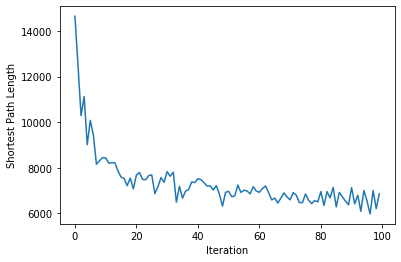

In [11]:
plt.plot(all_solutions[:, 0], all_solutions[:, 1])
plt.xlabel('Iteration')
plt.ylabel('Shortest Path Length')